 # Driver Safety Monitoring System
**Drowsiness Detection using Transfer Learning & Interpretability Analysis**

## Table of Contents
1. [Setup & Environment](#setup)
2. [Data Loading & Exploration](#data-loading)
3. [Data Cleaning & Preprocessing](#data-cleaning)
4. [Exploratory Data Analysis](#eda)
5. [Train/Val/Test Split](#data-split)
6. [Baseline Model (EAR)](#baseline)
7. [Deep Learning Model (MobileNetV2)](#deep-learning)
8. [Model Training](#training)
9. [Test Set Evaluation](#test-evaluation)
10. [Interpretability Analysis (Grad-CAM)](#grad-cam)
11. [External Validation](#external-validation)
12. [Alternative Approach](#perclos)

# 1. Setup & Environment Configuration

In [7]:
import torch

In [8]:
# Mount Google Drive to save our work
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
import os
project_dir = '/content/drive/MyDrive/DriverSafetySystem'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

print(f"Working directory: {os.getcwd()}")
print(f"GPU Available: {torch.cuda.is_available()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/DriverSafetySystem
GPU Available: True


In [9]:
!pip install -q kaggle opencv-python-headless mediapipe pillow matplotlib seaborn plotly pandas numpy scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [10]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [11]:
!pip install -q timm  # PyTorch Image Models

In [12]:
!pip install -q wandb albumentations ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.2 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import glob
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# DL
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import timm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [15]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [16]:
torch.__version__
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

# 2. Data Loading & Initial Exploration
**Dataset:** Driver Drowsiness Dataset (DDD)  
**Source:** Kaggle  
**Original Size:** 41,793 images  
**Classes:** Drowsy, Non-Drowsy

In [17]:
import kagglehub

path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'driver-drowsiness-dataset-ddd' dataset.
Path to dataset files: /kaggle/input/driver-drowsiness-dataset-ddd


In [18]:
import os

dataset_path = path + "/Driver Drowsiness Dataset (DDD)"

print(os.listdir(dataset_path))

['Non Drowsy', 'Drowsy']


In [36]:
# Count images
drowsy_path = os.path.join(dataset_path, "Drowsy")
non_drowsy_path = os.path.join(dataset_path, "Non Drowsy")

drowsy_images = os.listdir(drowsy_path)
non_drowsy_images = os.listdir(non_drowsy_path)
len_drowsy = len(drowsy_images)
len_non_drowsy = len(non_drowsy_images)
print(f"Drowsy images: {len_drowsy}")
print(f"Non Drowsy images: {len_non_drowsy}")
print(f"Total images: {len_drowsy +len_non_drowsy}")
print(f"\nClasses are balanced: {abs(len_drowsy - len_non_drowsy) < 100}")

Drowsy images: 22348
Non Drowsy images: 19445
Total images: 41793

Classes are balanced: False


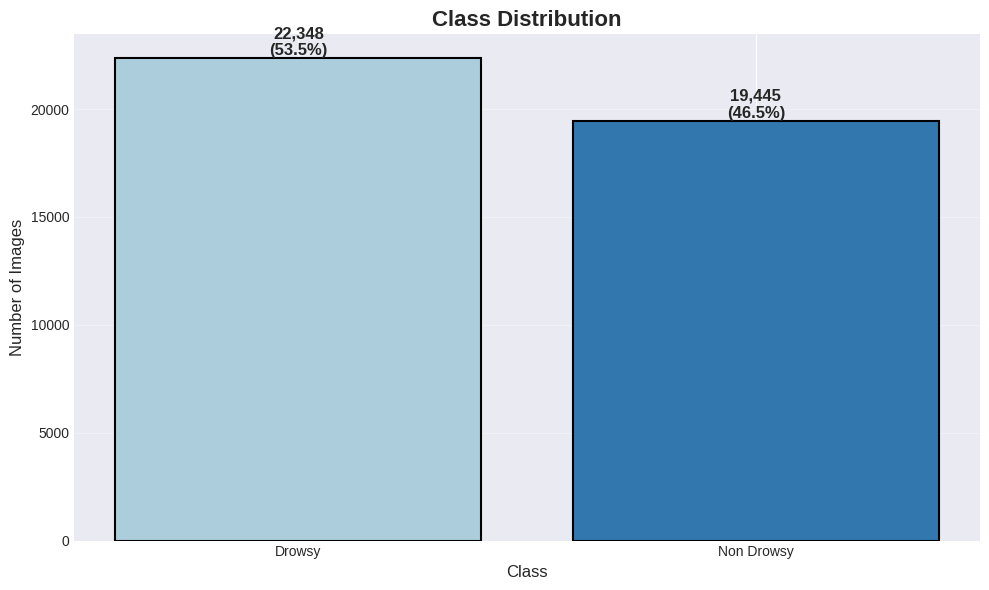

Imbalance Ratio: 1.15:1


In [38]:
import matplotlib.pyplot as plt

classes = ['Drowsy', 'Non Drowsy']
counts = [len_drowsy, len_non_drowsy]

# bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=['#accedc', '#3278af'], edgecolor='black', linewidth=1.5)

# count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/sum(counts)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Imbalance Ratio: {max(counts)/min(counts):.2f}:1")

# Check for:
- Corrupted images (won't load)
- Wrong format (not jpg/png)
- Wrong dimensions (too small/large)
- Duplicates (waste training time)
- Mislabeled images (drowsy labeled as alert)

# Must do:
- Resize images to same size (e.g., 224x224)
- Normalize pixel values (0-255 → 0-1 or -1 to 1)
- Convert to RGB (if grayscale or RGBA)
- Handle different aspect ratios

# Generate variations:
- Horizontal flip
- Rotation (±15°)
- Brightness adjustment
- Zoom in/out
- Random crops

# Handle imbalance:
- Class weights
- Stratified sampling
- Proper metrics

# Must understand:
- Class distribution
- Image quality/resolution
- Lighting conditions
- Data artifacts
- Edge cases

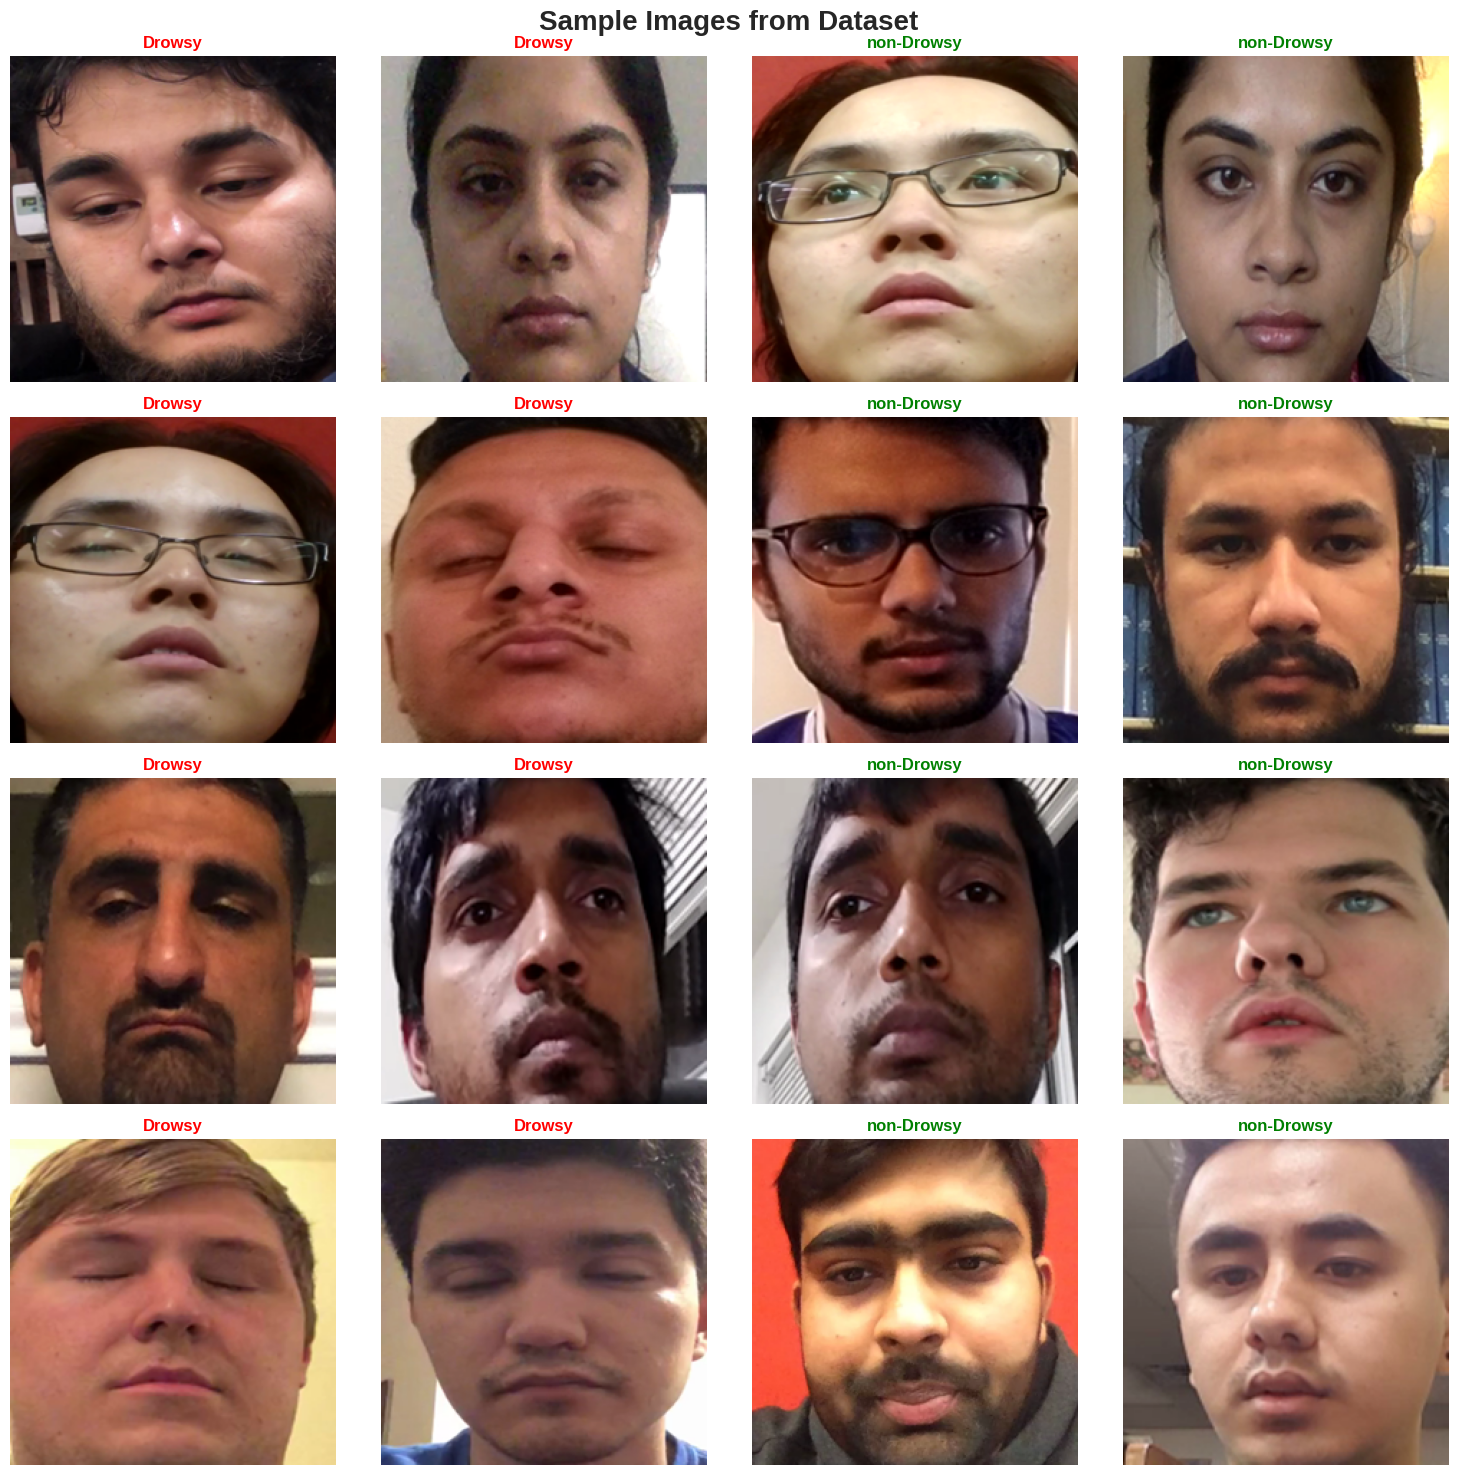

In [42]:
import cv2
import random
import os

#random samples
drowsy_samples = random.sample(os.listdir(drowsy_path), 8)
non_drowsy_samples = random.sample(os.listdir(non_drowsy_path), 8)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Sample Images from Dataset', fontsize=20, fontweight='bold', y=0.98)

# Plot drowsy images (left 2 columns)
for i in range(8):
    row = i // 2
    col = i % 2

    img_path = os.path.join(drowsy_path, drowsy_samples[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Drowsy', fontsize=12, fontweight='bold', color='red')
    axes[row, col].axis('off')

# Plot non-drowsy images (right 2 columns)
for i in range(8):
    row = i // 2
    col = i % 2 + 2

    img_path = os.path.join(non_drowsy_path, non_drowsy_samples[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'non-Drowsy', fontsize=12, fontweight='bold', color='green')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 3. Data Cleaning & Quality Analysis

## 3.1 Duplicate Detection

Using perceptual hashing (pHash) to identify duplicate images in the dataset.

why? so we cab remove near-duplicate images that could cause data leakage between train/val/test splits.

In [43]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 25.8 MB/s eta 0:00:00


In [44]:
from PIL import Image
import imagehash
import os

# Check drowsy images
print("Checking Drowsy images...")
drowsy_hashes = {}
drowsy_duplicates = 0

for img_name in os.listdir(drowsy_path):
    img = Image.open(os.path.join(drowsy_path, img_name))
    img_hash = str(imagehash.average_hash(img))

    if img_hash in drowsy_hashes:
        drowsy_duplicates += 1
    else:
        drowsy_hashes[img_hash] = img_name

# Check non-drowsy images
print("Checking Non-Drowsy images...")
non_drowsy_hashes = {}
non_drowsy_duplicates = 0

for img_name in os.listdir(non_drowsy_path):
    img = Image.open(os.path.join(non_drowsy_path, img_name))
    img_hash = str(imagehash.average_hash(img))

    if img_hash in non_drowsy_hashes:
        non_drowsy_duplicates += 1
    else:
        non_drowsy_hashes[img_hash] = img_name

print(f"Drowsy duplicates: {drowsy_duplicates}")
print(f"Non-Drowsy duplicates: {non_drowsy_duplicates}")

Checking Drowsy images...


KeyboardInterrupt: 

## 3.2 Data Cleaning & Deduplication

Creating a clean dataset by removing duplicates identified via perceptual hashing.


In [ ]:
import shutil

# Create clean dataset folder
clean_dataset_path = os.path.join(project_dir, "clean_dataset")
os.makedirs(os.path.join(clean_dataset_path, "Drowsy"), exist_ok=True)
os.makedirs(os.path.join(clean_dataset_path, "Non Drowsy"), exist_ok=True)

# Clean Drowsy images
print("Cleaning Drowsy images...")
drowsy_hashes = {}
drowsy_kept = 0

for img_name in os.listdir(drowsy_path):
    img_path = os.path.join(drowsy_path, img_name)
    img = Image.open(img_path)
    img_hash = str(imagehash.average_hash(img))

    if img_hash not in drowsy_hashes:
        # Keep this image (first occurrence)
        drowsy_hashes[img_hash] = img_name
        shutil.copy(img_path, os.path.join(clean_dataset_path, "Drowsy", img_name))
        drowsy_kept += 1

# Clean Non-Drowsy images
print("Cleaning Non-Drowsy images...")
non_drowsy_hashes = {}
non_drowsy_kept = 0

for img_name in os.listdir(non_drowsy_path):
    img_path = os.path.join(non_drowsy_path, img_name)
    img = Image.open(img_path)
    img_hash = str(imagehash.average_hash(img))

    if img_hash not in non_drowsy_hashes:
        # Keep this image
        non_drowsy_hashes[img_hash] =  img_name
        shutil.copy(img_path, os.path.join(clean_dataset_path, "Non Drowsy", img_name))
        non_drowsy_kept += 1

print(f"Location: {clean_dataset_path}")
print(f"Drowsy: {drowsy_kept} unique images (removed {len_drowsy - drowsy_kept} duplicates)")
print(f"Non-Drowsy: {non_drowsy_kept} unique images (removed {len_non_drowsy - non_drowsy_kept} duplicates)")

In [ ]:
drowsy_count = len_drowsy - drowsy_kept
non_drowsy_count = len_non_drowsy - non_drowsy_kept
total_count = drowsy_count + non_drowsy_count

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
classes = ['Drowsy', 'Non-Drowsy']
counts = [drowsy_count, non_drowsy_count]
bars = ax1.bar(classes, counts, color=['#accedc', '#3278af'], edgecolor='black', linewidth=2)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/total_count*100:.1f}%)',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_title('Clean Dataset Distribution', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# # Pie chart
# ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90,
#         colors=['#accedc', '#3278af'], explode=(0.05, 0.05),
#         shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
# ax2.set_title('Class Proportion', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Exploratory Data Analysis (EDA)

## 4.1 Image Dimensions Analysis

Analyzing image dimensions and aspect ratios to inform preprocessing decisions

In [46]:
# Sample 500 images from each class to analyze dimensions
drowsy_files = os.listdir(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", "Drowsy"))
non_drowsy_files = os.listdir(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", "Non Drowsy"))

sample_drowsy = random.sample(drowsy_files, min(500, len(drowsy_files)))
sample_non_drowsy = random.sample(non_drowsy_files, min(500, len(non_drowsy_files)))

widths, heights, aspect_ratios = [], [], []

print("Analyzing...\n")

for img_name in sample_drowsy + sample_non_drowsy:
    class_folder = "Drowsy" if img_name in sample_drowsy else "Non Drowsy"
    img = cv2.imread(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", class_folder, img_name))
    if img is not None:
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)

Analyzing...



In [47]:
# stats
print(f"Dimension Statistics (from {len(widths)} images):")
print(f"\nWidth:")
print(f"Min: {min(widths)}px")
print(f"Max: {max(widths)}px")
print(f"Mean: {np.mean(widths):.0f}px")
print(f"Median: {np.median(widths):.0f}px")

print(f"\nHeight:")
print(f"Min: {min(heights)}px")
print(f"Max: {max(heights)}px")
print(f"Mean: {np.mean(heights):.0f}px")
print(f"Median: {np.median(heights):.0f}px")

print(f"\nAspect Ratio (W/H):")
print(f"Min: {min(aspect_ratios):.2f}")
print(f"Max: {max(aspect_ratios):.2f}")
print(f"Mean: {np.mean(aspect_ratios):.2f}")

Dimension Statistics (from 1000 images):

Width:
Min: 227px
Max: 227px
Mean: 227px
Median: 227px

Height:
Min: 227px
Max: 227px
Mean: 227px
Median: 227px

Aspect Ratio (W/H):
Min: 1.00
Max: 1.00
Mean: 1.00


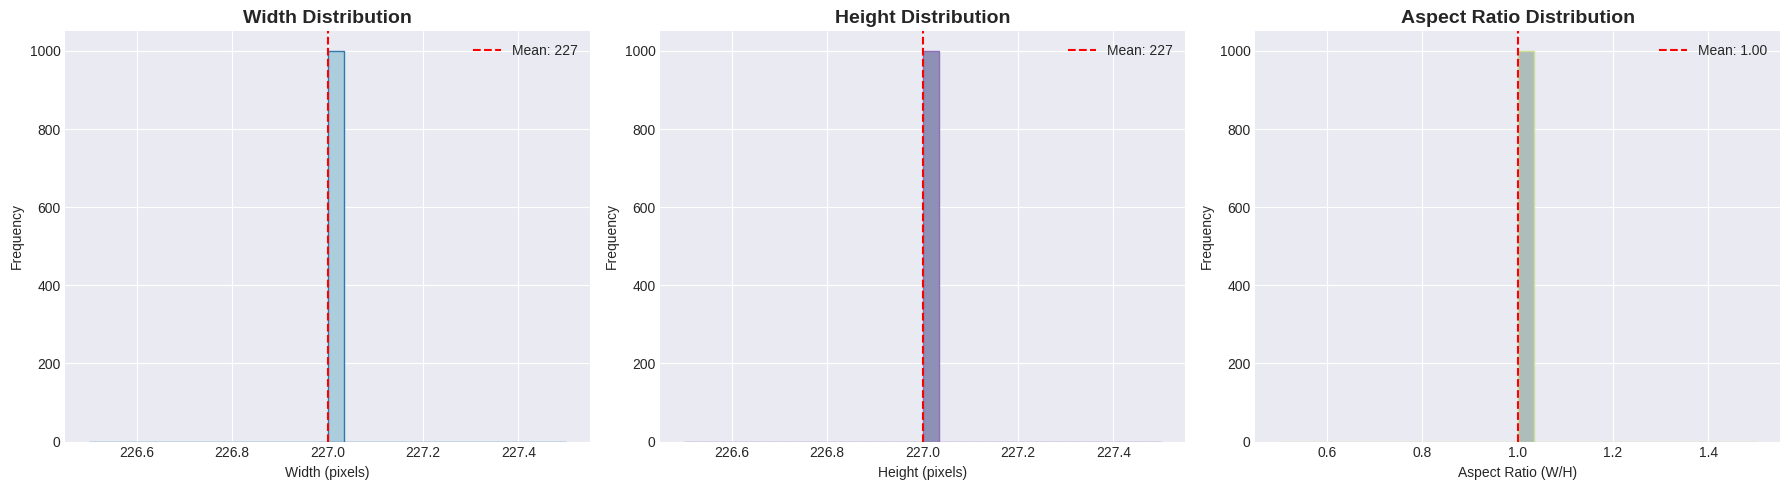

In [49]:
# visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(widths, bins=30, color='#accedc', edgecolor='#3278af')
axes[0].set_title('Width Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
axes[0].legend()

axes[1].hist(heights, bins=30, color='#8e90b6', edgecolor='#906fb6')
axes[1].set_title('Height Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
axes[1].legend()

axes[2].hist(aspect_ratios, bins=30, color='#afbdba', edgecolor='#cbe093')
axes[2].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

In [50]:
brightness_vals = []
contrast_vals = []

sample_images = random.sample(drowsy_files + non_drowsy_files, 500)

for img_name in sample_images:
    class_folder = "Drowsy" if img_name in drowsy_files else "Non Drowsy"
    img = cv2.imread(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", class_folder, img_name))
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness_vals.append(np.mean(gray))
        contrast_vals.append(np.std(gray))

print(f"Pixel Statistics (from {len(brightness_vals)} images):")
print(f"\nBrightness (Mean pixel value):")
print(f"Min: {min(brightness_vals):.1f}")
print(f"Max: {max(brightness_vals):.1f}")
print(f"Mean: {np.mean(brightness_vals):.1f}")
print(f"Std: {np.std(brightness_vals):.1f}")

print(f"\nContrast (Std of pixel values):")
print(f"Min: {min(contrast_vals):.1f}")
print(f"Max: {max(contrast_vals):.1f}")
print(f"Mean: {np.mean(contrast_vals):.1f}")
print(f"Std: {np.std(contrast_vals):.1f}")

Pixel Statistics (from 500 images):

Brightness (Mean pixel value):
Min: 38.4
Max: 172.1
Mean: 104.1
Std: 23.9

Contrast (Std of pixel values):
Min: 24.7
Max: 99.4
Mean: 52.7
Std: 11.3


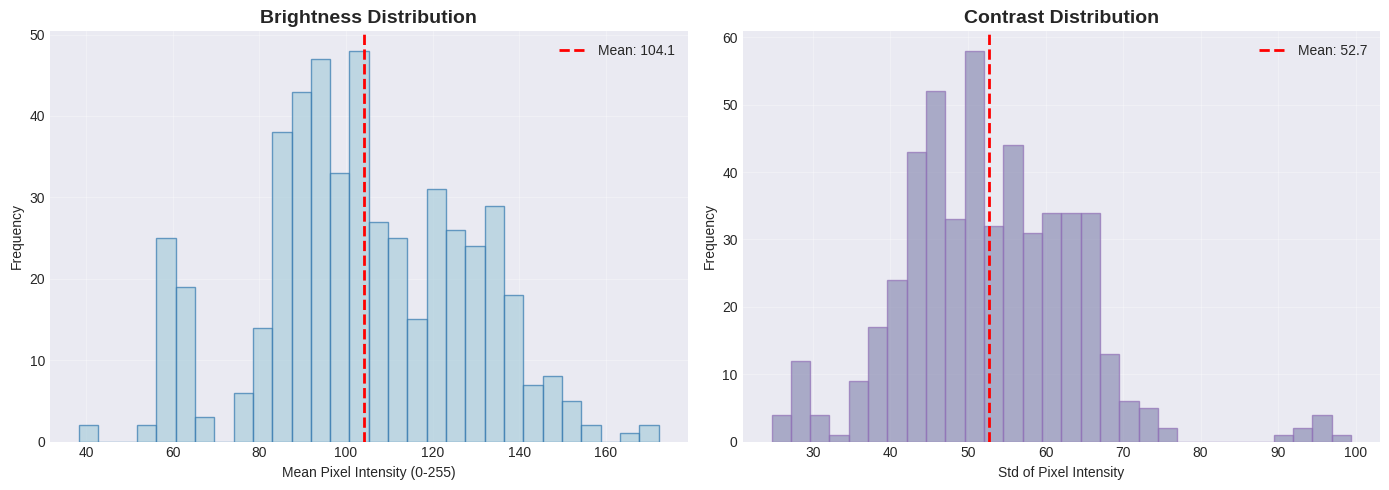

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(brightness_vals, bins=30, color='#accedc', edgecolor='#3278af', alpha=0.7)
axes[0].set_title('Brightness Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mean Pixel Intensity (0-255)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(brightness_vals), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(brightness_vals):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(contrast_vals, bins=30, color='#8e90b6', edgecolor='#906fb6', alpha=0.7)
axes[1].set_title('Contrast Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Std of Pixel Intensity')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(contrast_vals), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(contrast_vals):.1f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
import shutil

In [53]:
clean_dataset_path= "/content/drive/MyDrive/DriverSafetySystem/clean_dataset"

In [54]:
drowsy_images = [os.path.join(clean_dataset_path, "Drowsy", f)
                 for f in os.listdir(os.path.join(clean_dataset_path, "Drowsy"))]
non_drowsy_images = [os.path.join(clean_dataset_path, "Non Drowsy", f)
                     for f in os.listdir(os.path.join(clean_dataset_path, "Non Drowsy"))]

In [55]:
all_images = drowsy_images + non_drowsy_images
all_labels = [0]*len(drowsy_images) + [1]*len(non_drowsy_images)  # 0=Drowsy, 1=Non-Drowsy

# 5. Train/Validation/Test Split

Creating stratified splits to maintain class balance across all sets.

**Split Ratio:**
- Train: 70%
- Validation: 15%
- Test: 15%


In [56]:
# First split: 70% train, 30% temp (for val+test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

# Second split: Split temp into 50% val, 50% test (15% and 15% of total)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=42
)

In [57]:
print(f"Train: {len(train_imgs)} images ({len(train_imgs)/len(all_images)*100:.1f}%)")
print(f"Val: {len(val_imgs)} images ({len(val_imgs)/len(all_images)*100:.1f}%)")
print(f"Test: {len(test_imgs)} images ({len(test_imgs)/len(all_images)*100:.1f}%)")

print(f"\nClass distribution per split:")
print(f"Train: Drowsy: {train_labels.count(0)}, Non-Drowsy: {train_labels.count(1)}")
print(f"Val: Drowsy: {val_labels.count(0)}, Non-Drowsy: {val_labels.count(1)}")
print(f"Test: Drowsy: {test_labels.count(0)}, Non-Drowsy: {test_labels.count(1)}")

Train: 13533 images (70.0%)
Val: 2900 images (15.0%)
Test: 2900 images (15.0%)

Class distribution per split:
Train: Drowsy: 7903, Non-Drowsy: 5630
Val: Drowsy: 1694, Non-Drowsy: 1206
Test: Drowsy: 1693, Non-Drowsy: 1207


In [58]:
# DF
train_df = pd.DataFrame({'image_path': train_imgs, 'label': train_labels})
val_df = pd.DataFrame({'image_path': val_imgs, 'label': val_labels})
test_df = pd.DataFrame({'image_path': test_imgs, 'label': test_labels})

In [59]:
# Save
splits_dir = os.path.join("/content/drive/MyDrive/DriverSafetySystem", 'data_splits')
os.makedirs(splits_dir, exist_ok=True)

train_df.to_csv(os.path.join(splits_dir, 'train.csv'), index=False)
val_df.to_csv(os.path.join(splits_dir, 'val.csv'), index=False)
test_df.to_csv(os.path.join(splits_dir, 'test.csv'), index=False)

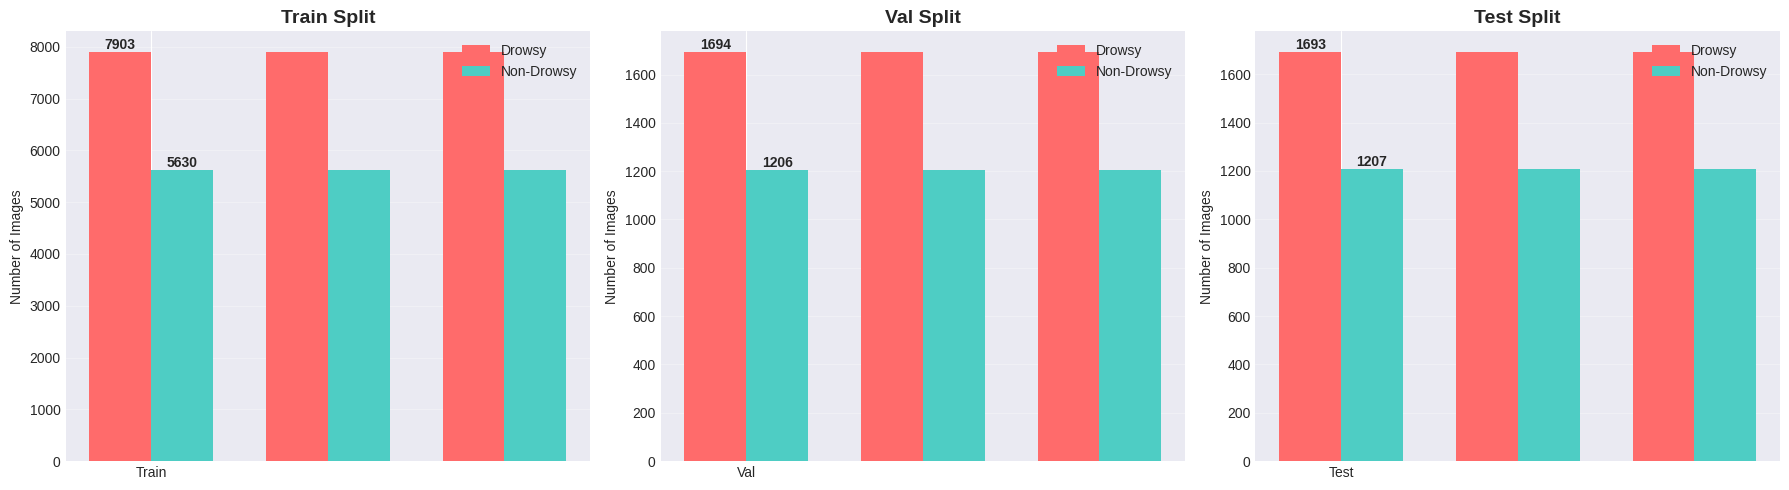

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = ['Train', 'Val', 'Test']
drowsy_counts = [train_labels.count(0), val_labels.count(0), test_labels.count(0)]
non_drowsy_counts = [train_labels.count(1), val_labels.count(1), test_labels.count(1)]

x = np.arange(len(splits))
width = 0.35

for i, ax in enumerate(axes):
    ax.bar(x - width/2, [drowsy_counts[i]], width, label='Drowsy', color='#FF6B6B')
    ax.bar(x + width/2, [non_drowsy_counts[i]], width, label='Non-Drowsy', color='#4ECDC4')
    ax.set_title(f'{splits[i]} Split', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Images')
    ax.set_xticks([0])
    ax.set_xticklabels([splits[i]])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add count labels
    ax.text(0 - width/2, drowsy_counts[i], f'{drowsy_counts[i]}',
            ha='center', va='bottom', fontweight='bold')
    ax.text(0 + width/2, non_drowsy_counts[i], f'{non_drowsy_counts[i]}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---

# 6. Data Preprocessing & Augmentation

## 6.1 Transformations

Setting up data augmentation for training and normalization for all sets.

**Training Augmentation:**
- Random horizontal flip
- Random rotation (±15°)
- Color jitter (brightness, contrast, saturation)
- Random affine transformations


In [22]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

In [24]:
# ImageNet normalization (standard for transfer learning)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [62]:
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [25]:
# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [64]:
from torch.utils.data import Dataset
class DrowsinessDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [65]:
# Create datasets
train_dataset = DrowsinessDataset(train_df, transform=train_transform)
val_dataset = DrowsinessDataset(val_df, transform=val_test_transform)
test_dataset = DrowsinessDataset(test_df, transform=val_test_transform)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

Train dataset: 13533 images
Val dataset: 2900 images
Test dataset: 2900 images


In [67]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [68]:
print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 32
Train batches: 423
Val batches: 91
Test batches: 91


In [69]:
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


# 7. Baseline Model: Eye Aspect Ratio (EAR)

Implementing a rule-based baseline using MediaPipe face landmarks and Eye Aspect Ratio calculations.

**Method:**
- Detect facial landmarks using MediaPipe
- Calculate EAR = (vertical distances) / (horizontal distance)
- Threshold: EAR < 0.25 → Drowsy



In [32]:
import mediapipe as mp

In [34]:
# initialize mediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

In [35]:
# Eye landmark indices (MediaPipe face mesh)
LEFT_EYE_INDICES = [33, 160, 158, 133, 153, 144]
RIGHT_EYE_INDICES = [362, 385, 387, 263, 373, 380]

In [36]:
def calculate_ear(eye_landmarks):
    A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
    B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])
    C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [37]:
def detect_drowsiness_baseline(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        return None, None

    landmarks = results.multi_face_landmarks[0].landmark
    h, w = image.shape[:2]

    # Extract eye coordinates
    left_eye = np.array([(landmarks[i].x * w, landmarks[i].y * h)
                         for i in LEFT_EYE_INDICES])
    right_eye = np.array([(landmarks[i].x * w, landmarks[i].y * h)
                          for i in RIGHT_EYE_INDICES])

    # Calculate EAR
    left_ear = calculate_ear(left_eye)
    right_ear = calculate_ear(right_eye)
    avg_ear = (left_ear + right_ear) / 2.0

    # Threshold
    EAR_THRESHOLD = 0.25
    prediction = 0 if avg_ear < EAR_THRESHOLD else 1

    return prediction, avg_ear

In [75]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [76]:
# Test on validation set
val_predictions = []
val_true_labels = []
val_ear_values = []
failed_detections = 0

for idx in tqdm(range(len(val_df)), desc="Evaluating baseline"):
    img_path = val_df.iloc[idx]['image_path']
    true_label = val_df.iloc[idx]['label']

    pred, ear_val = detect_drowsiness_baseline(img_path)

    if pred is not None:
        val_predictions.append(pred)
        val_true_labels.append(true_label)
        val_ear_values.append(ear_val)
    else:
        failed_detections += 1

Evaluating baseline: 100%|██████████| 2900/2900 [22:55<00:00,  2.11it/s]


Total validation images: 2900
Successfully processed: 2895
Failed detections: 5
Accuracy: 66.46%
              precision    recall  f1-score   support

      Drowsy       0.71      0.71      0.71      1689
  Non-Drowsy       0.60      0.61      0.60      1206

    accuracy                           0.66      2895
   macro avg       0.66      0.66      0.66      2895
weighted avg       0.67      0.66      0.66      2895



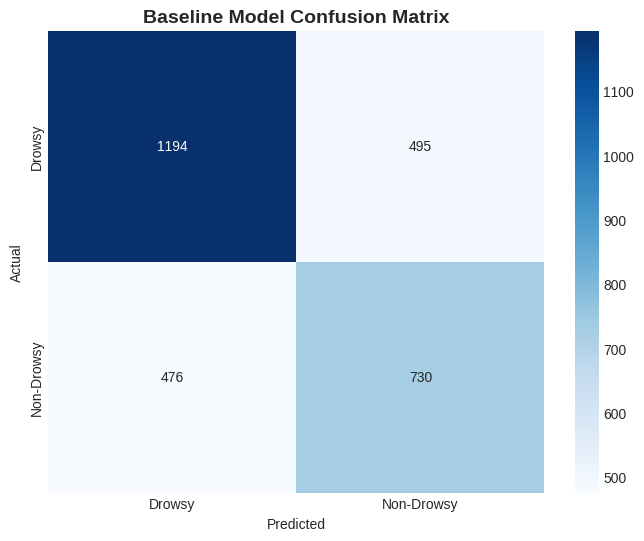

In [77]:
#Calculate metrics
baseline_accuracy = accuracy_score(val_true_labels, val_predictions)

print(f"Total validation images: {len(val_df)}")
print(f"Successfully processed: {len(val_predictions)}")
print(f"Failed detections: {failed_detections}")
print(f"Accuracy: {baseline_accuracy*100:.2f}%")

print(classification_report(val_true_labels, val_predictions,
                           target_names=['Drowsy', 'Non-Drowsy']))

# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Drowsy', 'Non-Drowsy'],
            yticklabels=['Drowsy', 'Non-Drowsy'])
plt.title('Baseline Model Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 8. MobileNetV2 Funetuning

## 8.1 Model Architecture

Using transfer learning with MobileNetV2 pretrained on ImageNet.

**Architecture:**
- Base: MobileNetV2 (pretrained on ImageNet)
- Output: 2 classes (Drowsy, Non-Drowsy)
- Parameters: ~2.26M trainable


In [33]:
import torch.nn as nn
import timm
from torch import optim
from tqdm import tqdm
import time

In [79]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


In [80]:
# Load pre-trained MobileNetV2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=2)

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [81]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 2,226,434
Trainable parameters: 2,226,434


## 8.2 Model Training

**Hyperparameters:**
- Optimizer: Adam (lr=0.001)
- Loss: CrossEntropyLoss with class weights
- Batch size: 32
- Early stopping: patience=3
- Scheduler: ReduceLROnPlateau

**Hardware:** NVIDIA L4 GPU (23.8GB)

In [82]:
# Move model to device
model = model.to(device)

In [83]:
# Loss function with class weights (handle imbalance)
class_weights = torch.tensor([1.0, 1.29]).to(device)  # Drowsy, Non-Drowsy
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [87]:
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [88]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [89]:
# Training hyperparameters
NUM_EPOCHS = 10
EARLY_STOPPING_PATIENCE = 3

In [90]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

In [91]:
# Track best model
best_val_acc = 0.0
best_model_path = os.path.join("/content/drive/MyDrive/DriverSafetySystem", 'best_model.pth')
patience_counter = 0

In [92]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

In [93]:
# Start training
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Training complete
total_time = time.time() - start_time

print(f"Total time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved: {best_model_path}")
print(f"\nBaseline accuracy: {baseline_accuracy*100:.2f}%")
print(f"MobileNetV2 accuracy: {best_val_acc:.2f}%")

Epoch 1/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.64it/s]


Train Loss: 0.1917 | Train Acc: 96.06%
Val Loss: 0.2546 | Val Acc: 95.97%
New best model saved! Val Acc: 95.97%
Epoch 2/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.87it/s]


Train Loss: 0.0546 | Train Acc: 98.62%
Val Loss: 0.0140 | Val Acc: 99.34%
New best model saved! Val Acc: 99.34%
Epoch 3/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.68it/s]


Train Loss: 0.0277 | Train Acc: 99.21%
Val Loss: 0.0020 | Val Acc: 99.93%
New best model saved! Val Acc: 99.93%
Epoch 4/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.70it/s]


Train Loss: 0.0208 | Train Acc: 99.42%
Val Loss: 0.0030 | Val Acc: 99.93%
No improvement. Patience: 1/3
Epoch 5/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.49it/s]


Train Loss: 0.0380 | Train Acc: 98.94%
Val Loss: 0.0017 | Val Acc: 99.93%
No improvement. Patience: 2/3
Epoch 6/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.72it/s]

Train Loss: 0.0213 | Train Acc: 99.40%
Val Loss: 0.0022 | Val Acc: 99.90%
No improvement. Patience: 3/3

Early stopping triggered after 6 epochs
Total time: 53.59 minutes
Best validation accuracy: 99.93%
Best model saved: /content/drive/MyDrive/DriverSafetySystem/best_model.pth

Baseline accuracy: 66.46%
MobileNetV2 accuracy: 99.93%


# 9. Test Set Evaluation

Evaluating the trained model on the held-out test set.


In [27]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

NameError: name 'model' is not defined

In [95]:
# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}%")

Validation: 100%|██████████| 91/91 [10:06<00:00,  6.67s/it]

Test Loss: 0.0014
Test Accuracy: 100.0000%


In [96]:
print(classification_report(test_labels, test_preds,
                           target_names=['Drowsy (0)', 'Non-Drowsy (1)'],
                           digits=4))

                precision    recall  f1-score   support

    Drowsy (0)     1.0000    1.0000    1.0000      1693
Non-Drowsy (1)     1.0000    1.0000    1.0000      1207

      accuracy                         1.0000      2900
     macro avg     1.0000    1.0000    1.0000      2900
  weighted avg     1.0000    1.0000    1.0000      2900



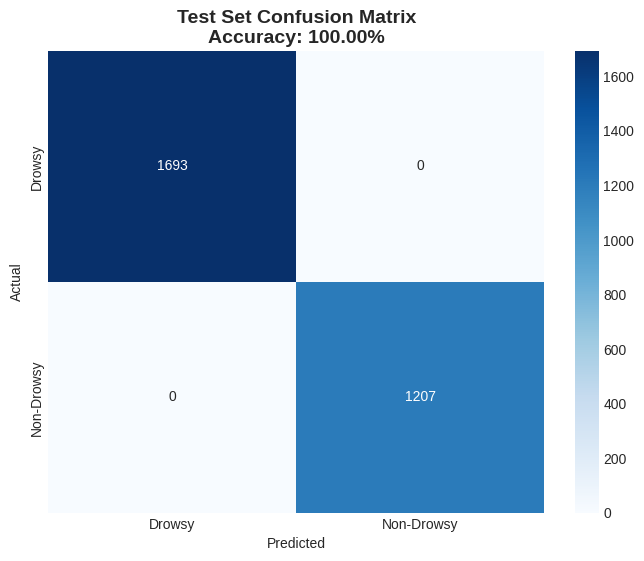

In [97]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Drowsy', 'Non-Drowsy'],
            yticklabels=['Drowsy', 'Non-Drowsy'])
plt.title(f'Test Set Confusion Matrix\nAccuracy: {test_acc:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [98]:
# Count errors
errors = [i for i, (p, t) in enumerate(zip(test_preds, test_labels)) if p != t]
print(f"Total test images: {len(test_labels)}")
print(f"Correct predictions: {len(test_labels) - len(errors)}")
print(f"Incorrect predictions: {len(errors)}")
print(f"Error rate: {len(errors)/len(test_labels)*100:.4f}%")

Total test images: 2900
Correct predictions: 2900
Incorrect predictions: 0
Error rate: 0.0000%


---

# 10. Interpretability Analysis: Grad-CAM

## 10.1 What is Grad-CAM?

**Grad-CAM (Gradient-weighted Class Activation Mapping)** is an interpretability technique that:
- Visualizes which regions of an image the model focuses on
- Uses gradients flowing into the final convolutional layer
- Produces heatmaps showing important regions for predictions

**Goal:** Understand *what* the model learned, not just *how well* it performs.

**Research Question:** Does the model focus on semantically relevant features (eyes) or spurious correlations (head angles, background)?


## 10.2 Grad-CAM Implementation

In [99]:
import torch.nn.functional as F

In [105]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = torch.mean(gradients, dim=(1, 2))

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy()

In [106]:
# Find last convolutional layer
last_conv_layer = None
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        last_conv_layer = module

if last_conv_layer is None:
    print("Could not find convolutional layer!")
else:
    print("Found convolutional layer for Grad-CAM")
    gradcam = GradCAM(model, last_conv_layer)
    print("Grad-CAM initialized!")

Found convolutional layer for Grad-CAM
Grad-CAM initialized!


## 10.3 Grad-CAM Visualization

Analyzing model attention patterns on test set images

**Expected Finding:**
- If correct: High attention on eye regions
- If spurious: Attention on head angles, forehead, background

analyzing where the model focuses attention

In [1]:
def visualize_gradcam(image_path, model, gradcam, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()

    cam = gradcam.generate_cam(img_tensor, pred_class)

    img_np = np.array(img)
    h, w = img_np.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    return img_np, heatmap, overlay, pred_class, confidence

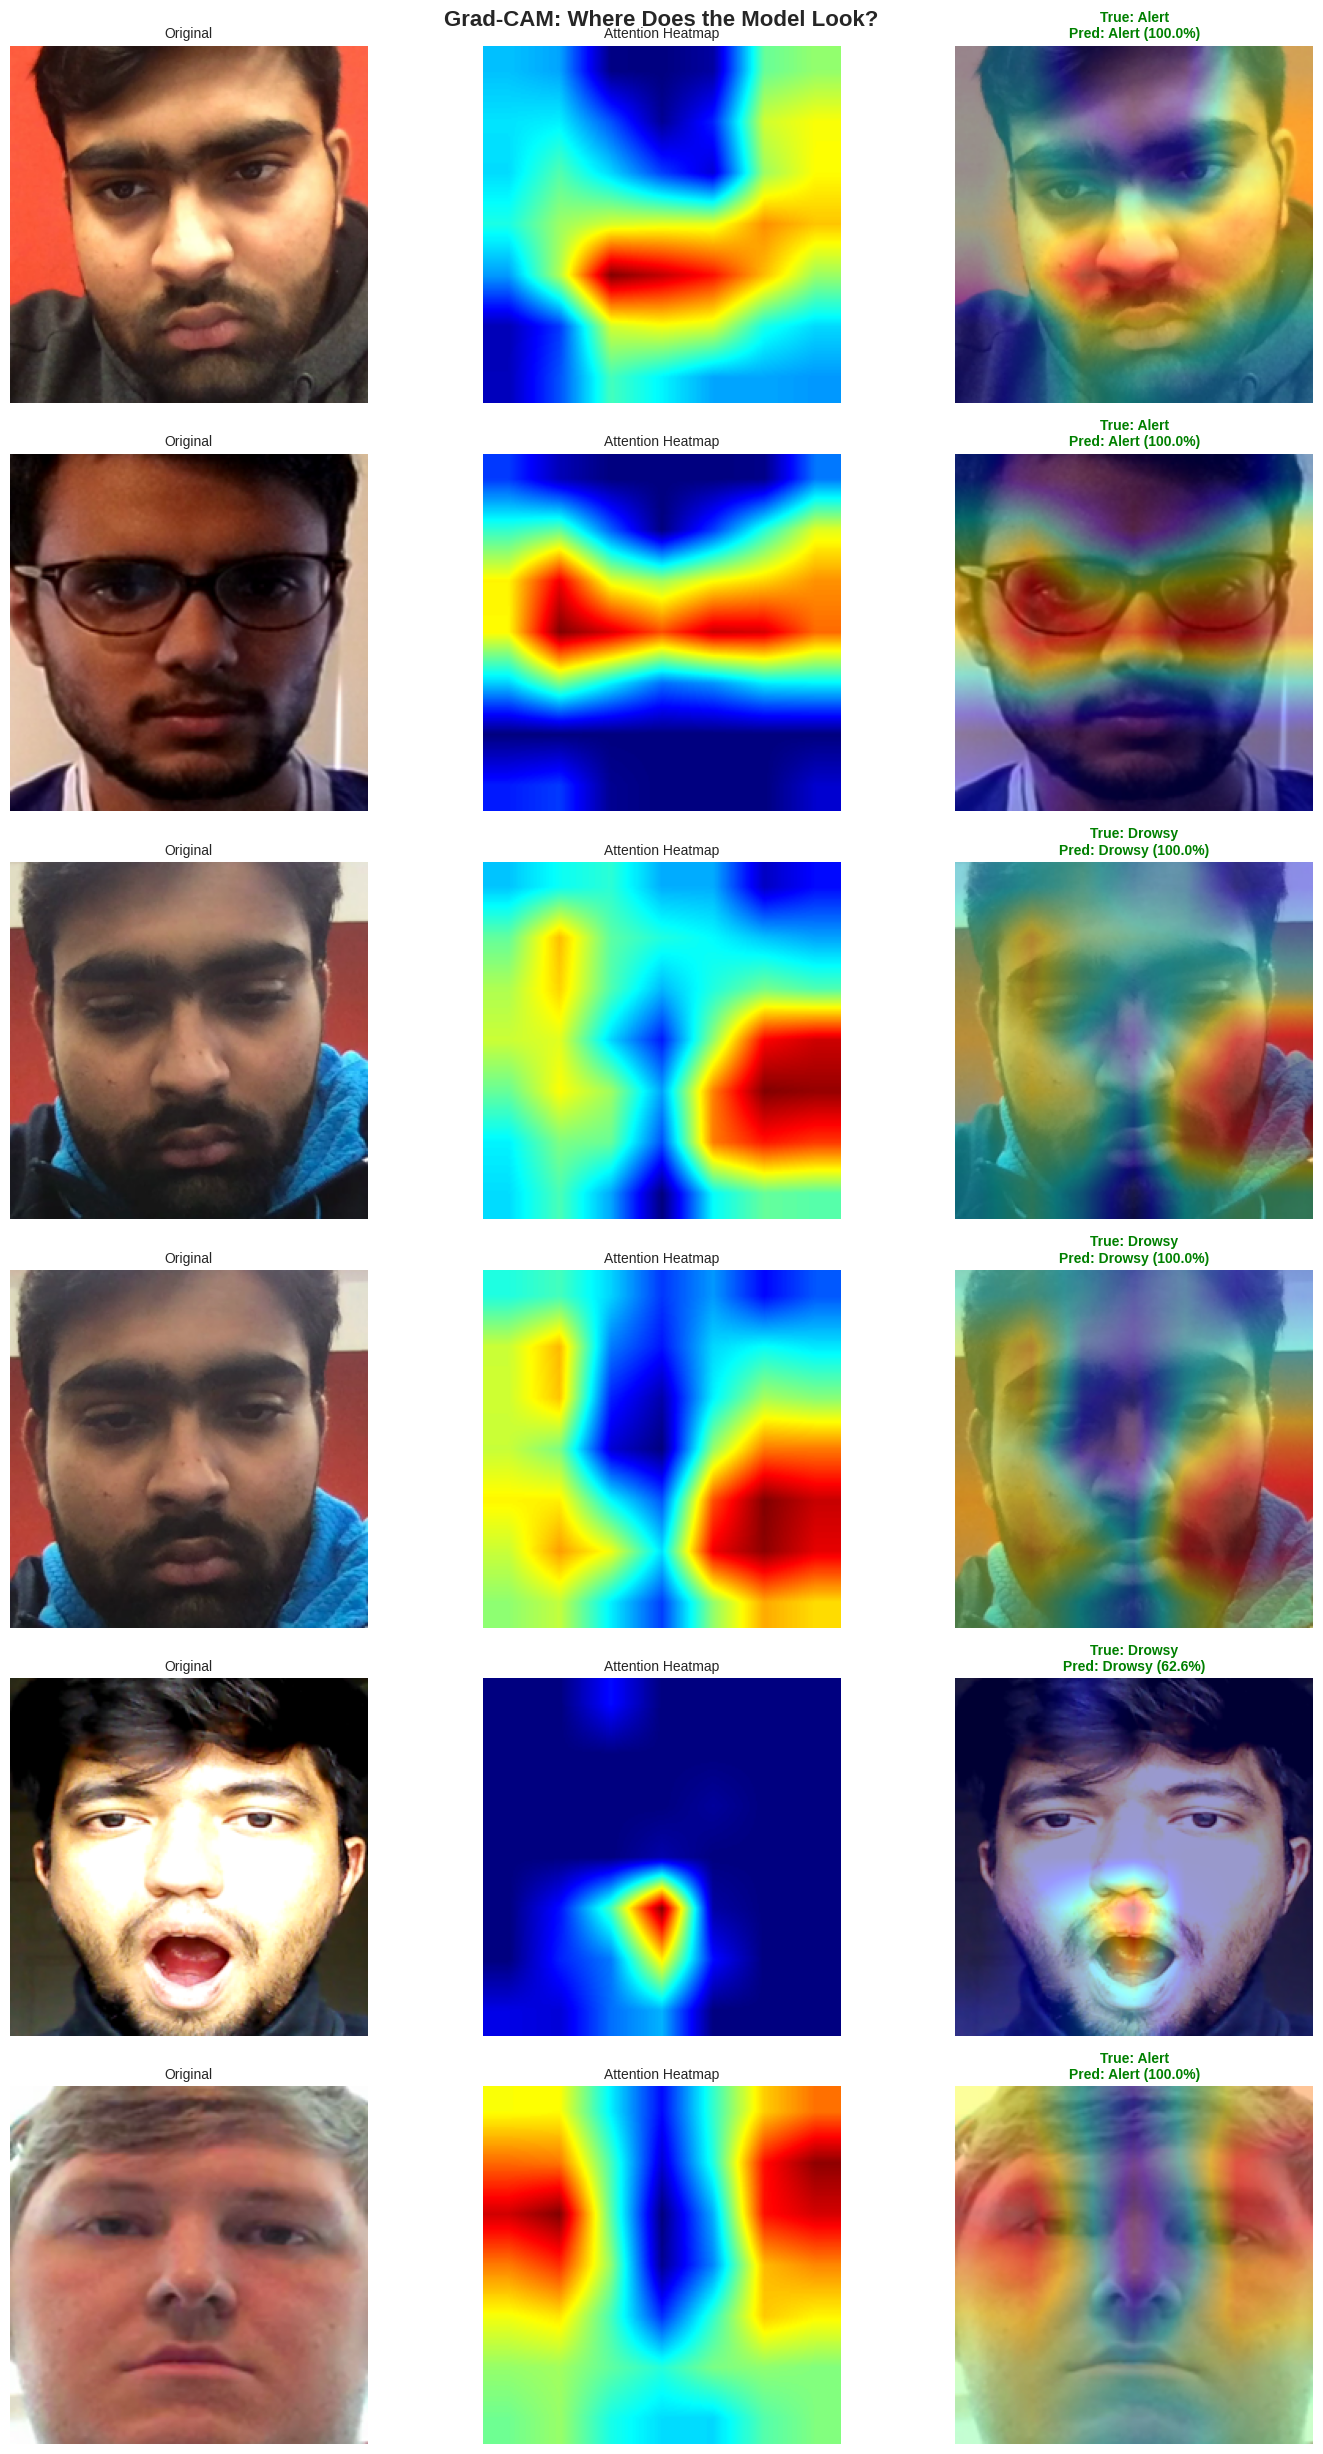

In [113]:
# Sample test images
sample_indices = random.sample(range(len(test_df)), 6)

fig, axes = plt.subplots(6, 3, figsize=(15, 25))
fig.suptitle('Grad-CAM: Where Does the Model Look?', fontsize=16, fontweight='bold')

for idx, test_idx in enumerate(sample_indices):
    img_path = test_df.iloc[test_idx]['image_path']
    true_label = test_df.iloc[test_idx]['label']

    original, heatmap, overlay, pred_class, confidence = visualize_gradcam(
        img_path, model, gradcam, val_test_transform, device
    )

    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title('Original', fontsize=10)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(heatmap)
    axes[idx, 1].set_title('Attention Heatmap', fontsize=10)
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(overlay)
    true_str = 'Drowsy' if true_label == 0 else 'Alert'
    pred_str = 'Drowsy' if pred_class == 0 else 'Alert'
    color = 'green' if true_label == pred_class else 'red'
    axes[idx, 2].set_title(f'True: {true_str}\nPred: {pred_str} ({confidence*100:.1f}%)',
                          fontsize=10, color=color, fontweight='bold')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

---

# 11. External Real-World Validation

Testing the model on images from different sources (not from the Kaggle dataset) to evaluate out-of-distribution performance.

**Test Images:**
- External dashcam images
- Different camera angles
- Different lighting conditions

**Purpose:** Validate whether high test accuracy translates to real-world reliability.

**Hypothesis:** If the model learned spurious correlations, it will fail on external images despite 99.96% test accuracy.

In [4]:
import os

In [20]:
external_images = [
    'test_1.png',  # Drowsy dashcam
    'test_2.png',  # Alert glasses
    'test_3.png',  # Alert glasses turned
    'test_4.png',  # Alert
    'test_5.png'   # Drowsy eyes closed
]

In [28]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [30]:
# Load the trained model
model = timm.create_model('mobilenetv2_100', pretrained=False, num_classes=2)
model.load_state_dict(torch.load(os.path.join(project_dir, 'best_model.pth')))
model = model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent


 Testing: test_1.png


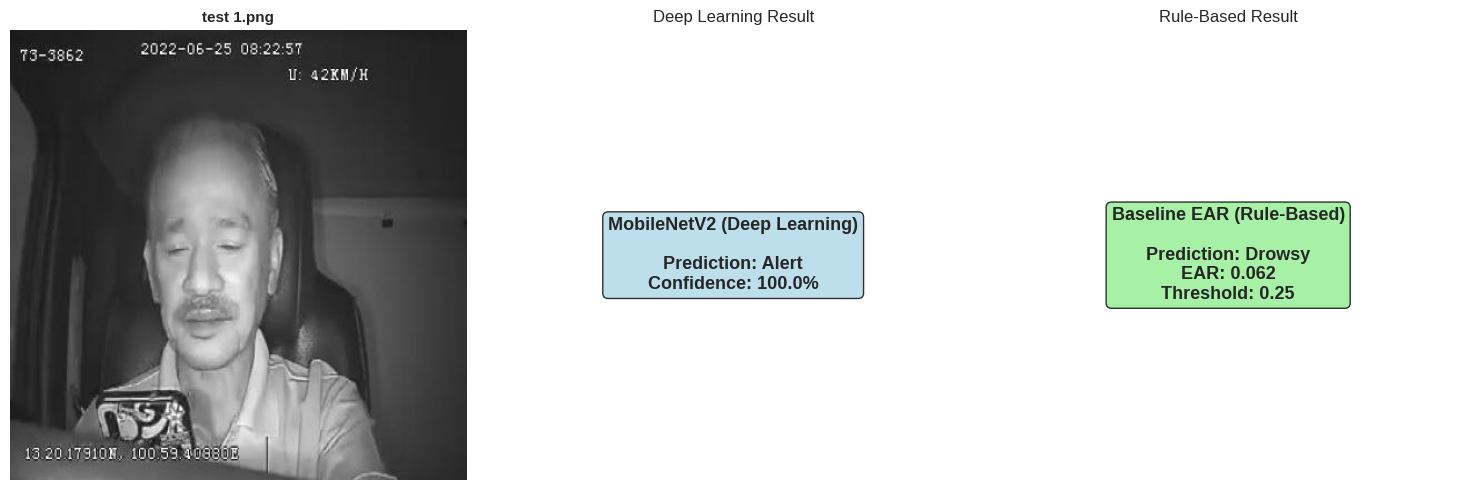

   MobileNetV2: Alert (100.0%)
   Baseline EAR: Drowsy (EAR=0.062)

 Testing: test_2.png


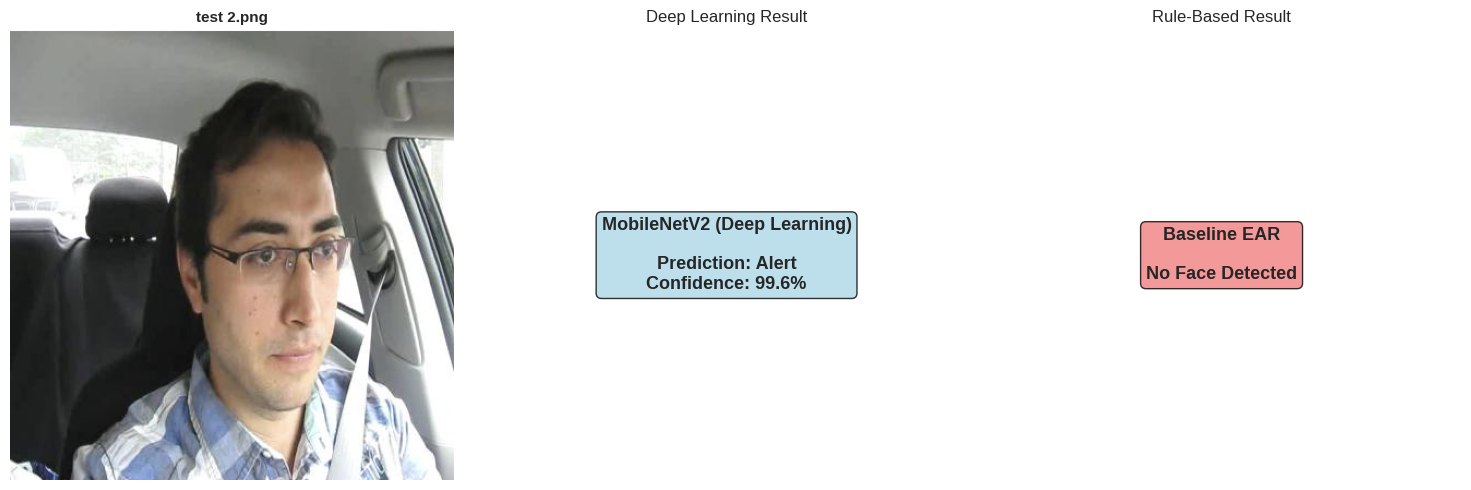

   MobileNetV2: Alert (99.6%)
   Baseline EAR: No face detected

 Testing: test_3.png


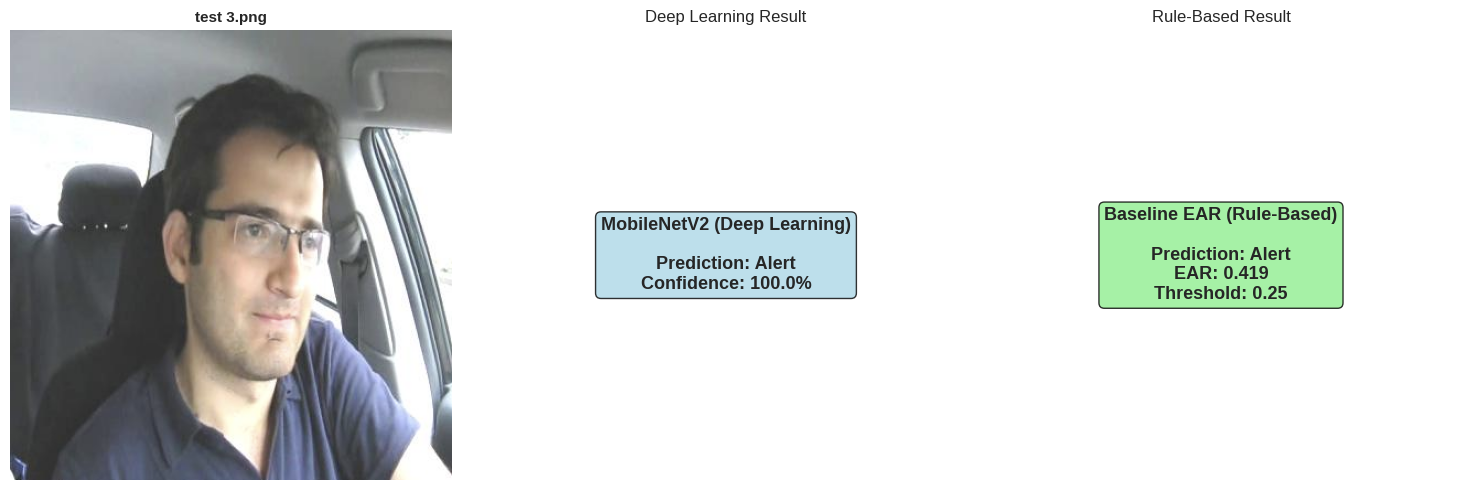

   MobileNetV2: Alert (100.0%)
   Baseline EAR: Alert (EAR=0.419)

 Testing: test_4.png


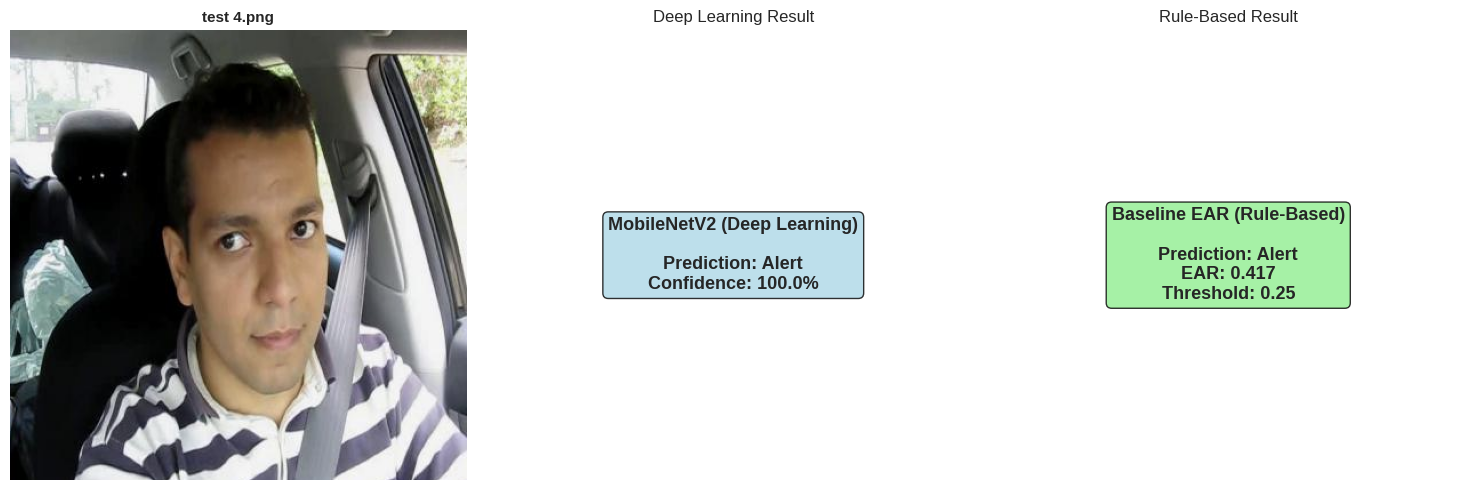

   MobileNetV2: Alert (100.0%)
   Baseline EAR: Alert (EAR=0.417)

 Testing: test_5.png


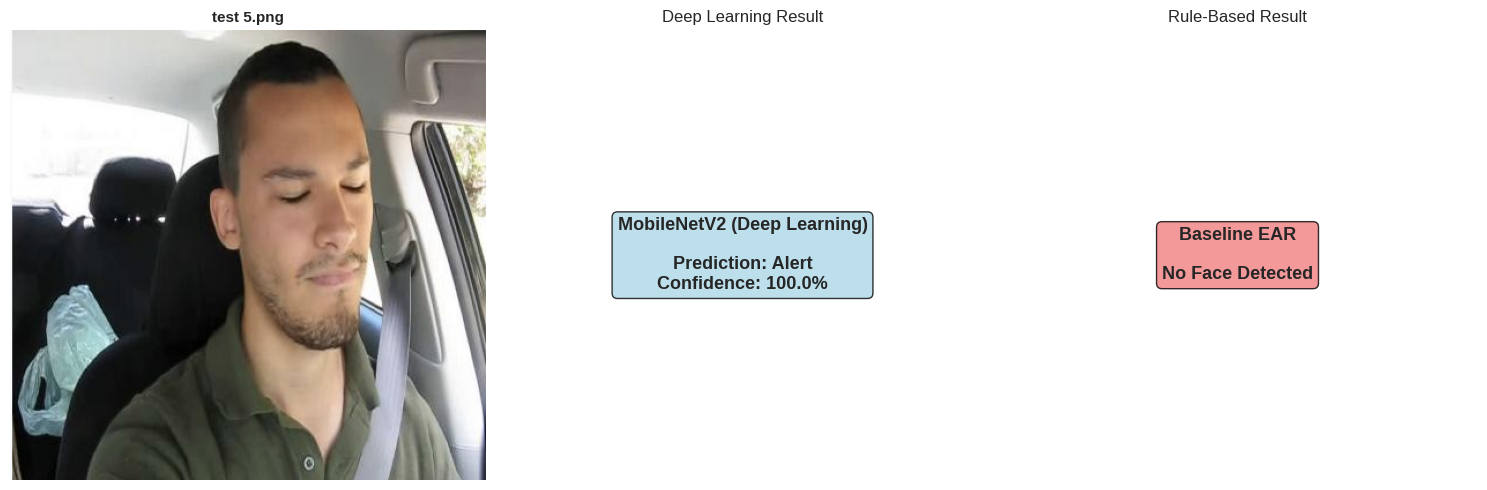

   MobileNetV2: Alert (100.0%)
   Baseline EAR: No face detected


In [38]:
for img_name in external_images:
    img_path = os.path.join(project_dir, img_name)

    if not os.path.exists(img_path):
        print(f"\n {img_name} not found, skipping...")
        continue

    print(f"\n Testing: {img_name}")

    # MobileNetV2 prediction
    img = Image.open(img_path).convert('RGB')
    img_tensor = val_test_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()

    dl_pred = 'Drowsy' if pred_class == 0 else 'Alert'

    # Baseline EAR prediction
    baseline_pred, ear_val = detect_drowsiness_baseline(img_path)
    baseline_label = 'Drowsy' if baseline_pred == 0 else 'Alert' if baseline_pred else 'No Face'

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title(img_name.replace('_', ' '), fontsize=11, fontweight='bold')
    axes[0].axis('off')

    axes[1].text(0.5, 0.5,
                f'MobileNetV2 (Deep Learning)\n\n'
                f'Prediction: {dl_pred}\n'
                f'Confidence: {confidence*100:.1f}%',
                ha='center', va='center', fontsize=13, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1].set_title('Deep Learning Result', fontsize=12)
    axes[1].axis('off')

    if baseline_pred is not None:
        axes[2].text(0.5, 0.5,
                    f'Baseline EAR (Rule-Based)\n\n'
                    f'Prediction: {baseline_label}\n'
                    f'EAR: {ear_val:.3f}\n'
                    f'Threshold: 0.25',
                    ha='center', va='center', fontsize=13, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        axes[2].text(0.5, 0.5, 'Baseline EAR\n\nNo Face Detected',
                    ha='center', va='center', fontsize=13, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

    axes[2].set_title('Rule-Based Result', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"   MobileNetV2: {dl_pred} ({confidence*100:.1f}%)")
    if baseline_pred is not None:
        print(f"   Baseline EAR: {baseline_label} (EAR={ear_val:.3f})")
    else:
        print(f"   Baseline EAR: No face detected")

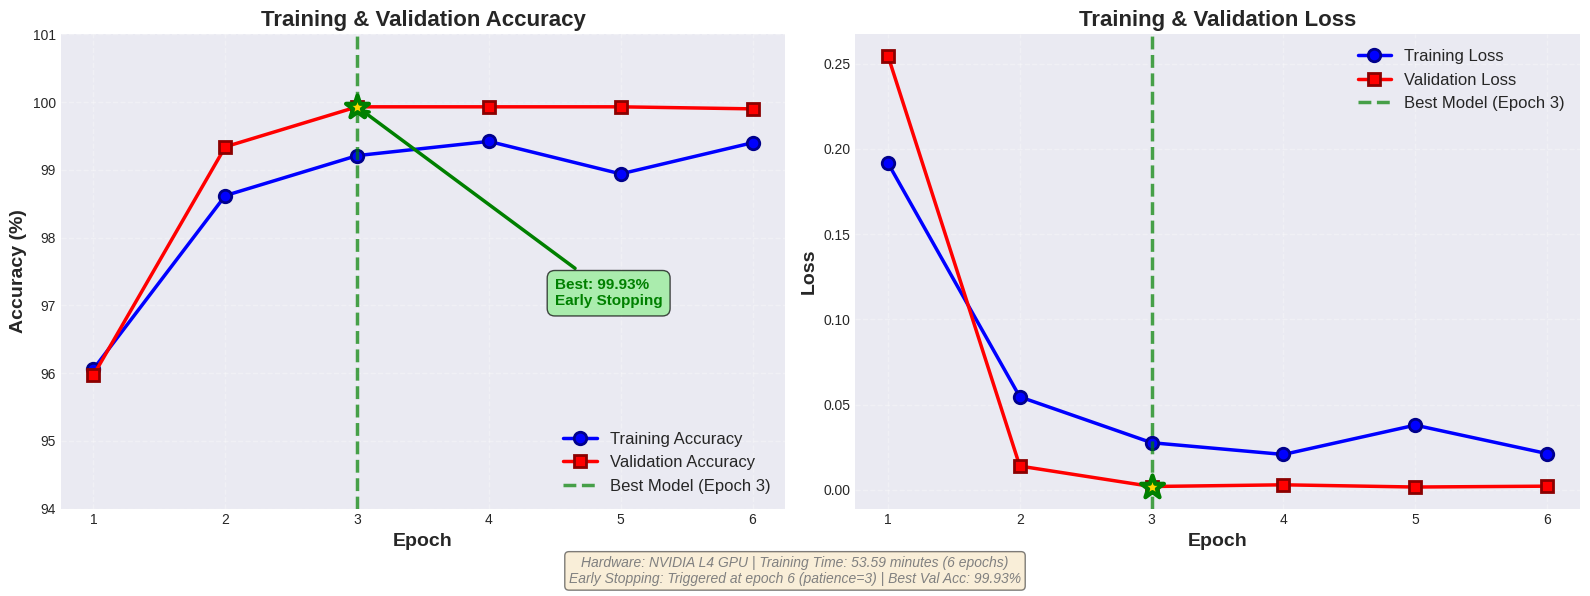

In [42]:
import matplotlib.pyplot as plt
import os

os.makedirs('images', exist_ok=True)

epochs = [1, 2, 3, 4, 5, 6]
train_loss = [0.1917, 0.0546, 0.0277, 0.0208, 0.0380, 0.0213]
train_acc = [96.06, 98.62, 99.21, 99.42, 98.94, 99.40]
val_loss = [0.2546, 0.0140, 0.0020, 0.0030, 0.0017, 0.0022]
val_acc = [95.97, 99.34, 99.93, 99.93, 99.93, 99.90]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, train_acc, 'b-o', label='Training Accuracy',
         linewidth=2.5, markersize=9, markerfacecolor='blue',
         markeredgewidth=2, markeredgecolor='darkblue')
ax1.plot(epochs, val_acc, 'r-s', label='Validation Accuracy',
         linewidth=2.5, markersize=9, markerfacecolor='red',
         markeredgewidth=2, markeredgecolor='darkred')

ax1.axvline(x=3, color='green', linestyle='--', linewidth=2.5, alpha=0.7,
            label='Best Model (Epoch 3)')
ax1.scatter([3], [99.93], color='gold', s=300, zorder=5,
            edgecolors='green', linewidth=3, marker='*')

ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Training & Validation Accuracy', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax1.grid(alpha=0.3, linestyle='--', linewidth=1)
ax1.set_ylim(94, 101)
ax1.set_xticks(epochs)

ax1.annotate('Best: 99.93%\nEarly Stopping',
             xy=(3, 99.93), xytext=(4.5, 97),
             arrowprops=dict(arrowstyle='->', color='green', lw=2.5),
             fontsize=11, fontweight='bold', color='green',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))



ax2.plot(epochs, train_loss, 'b-o', label='Training Loss',
         linewidth=2.5, markersize=9, markerfacecolor='blue',
         markeredgewidth=2, markeredgecolor='darkblue')
ax2.plot(epochs, val_loss, 'r-s', label='Validation Loss',
         linewidth=2.5, markersize=9, markerfacecolor='red',
         markeredgewidth=2, markeredgecolor='darkred')

ax2.axvline(x=3, color='green', linestyle='--', linewidth=2.5, alpha=0.7,
            label='Best Model (Epoch 3)')
ax2.scatter([3], [0.0020], color='gold', s=300, zorder=5,
            edgecolors='green', linewidth=3, marker='*')

ax2.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=14, fontweight='bold')
ax2.set_title('Training & Validation Loss', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12, loc='upper right', framealpha=0.9)
ax2.grid(alpha=0.3, linestyle='--', linewidth=1)
ax2.set_xticks(epochs)

info_text = (
    'Hardware: NVIDIA L4 GPU | Training Time: 53.59 minutes (6 epochs)\n'
    'Early Stopping: Triggered at epoch 6 (patience=3) | Best Val Acc: 99.93%'
)
fig.text(0.5, 0.02, info_text, ha='center', fontsize=10,
         style='italic', color='gray',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('images/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 12. Phase 3: Alternative Approach


In [ ]:
# to be continued

In [16]:
import json

with open('/content/01_Data_EDA_Drowsiness_Detection_new.ipynb', 'w') as f:
    nb = json.load(open('/content/01_Data_EDA_Drowsiness_Detection.ipynb'))
    nb['metadata'].pop('widgets', None)
    json.dump(nb, f)